<a href="https://colab.research.google.com/github/cpuguy96/stepmania-note-generator/blob/master/arrow_placement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from os import listdir
from os.path import isfile, join
import sys

import numpy as np
from nltk.util import ngrams
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dropout, Dense, Flatten, BatchNormalization, LSTM, Input, concatenate, Bidirectional
from keras.models import Sequential, Model, load_model
from keras.optimizers import Nadam

Using TensorFlow backend.


# Data Prep

In [2]:
! rm -rf sample_data
! git clone https://github.com/cpuguy96/stepmania-note-generator.git

Cloning into 'stepmania-note-generator'...
remote: Enumerating objects: 330, done.
remote: Counting objects: 100% (330/330), done.
remote: Compressing objects: 100% (283/283), done.
remote: Total 779 (delta 48), reused 329 (delta 47), pack-reused 449
Receiving objects: 100% (779/779), 306.26 MiB | 10.50 MiB/s, done.
Resolving deltas: 100% (130/130), done.
Checking out files: 100% (601/601), done.


In [0]:
input_dir = "stepmania-note-generator/"

In [4]:
def get_file_names(mypath):
    return [f for f in listdir(mypath) if isfile(join(mypath, f))]


def get_notes(notes_path):
    all_song_notes = []
    file_names = get_file_names(notes_path)
    
    for file_name in file_names:
        file_notes = []
        with open(notes_path + file_name, 'r') as file:
            lines = file.readlines()
            file_notes = np.asarray([x.replace("\n", "").split(" ") for x in lines[3:]])
        all_song_notes.append(file_notes)
    return np.asarray(all_song_notes)


notes_by_song = get_notes(input_dir + "timings/")
notes_by_song.shape

(105,)

In [54]:
def get_binary_rep(arrow_values):
    return (((np.asarray(arrow_values).astype(int)[:,None] & (1 << np.arange(4)))) > 0).astype(int)


def get_extended_binary_rep(arrow_combs):
    extended_binary_rep = []
    for i, arrow_comb in enumerate(arrow_combs):
        binary_rep = np.zeros((4, 4))
        for j, num in enumerate(list(arrow_comb)):
            binary_rep[int(num), j] = 1
        extended_binary_rep.append(binary_rep.ravel())
    return np.asarray(extended_binary_rep)


def create_tokens(timings):
    timings = timings.astype("float32")
    tokens = np.zeros((timings.shape[0], 3))
    tokens[0][0] = 1 # set start token
    next_note_token = np.append(timings[1:] - timings[:-1], np.asarray([0]))
    prev_note_token = np.append(np.asarray([0]),  next_note_token[: -1])
    tokens[:, 1] = prev_note_token.reshape(1, -1)
    tokens[:, 2] = next_note_token.reshape(1, -1)
    return tokens.astype("float32")


def get_notes_ngram(binary_notes, lookback):
    padding = np.zeros((lookback, binary_notes.shape[1]))
    data_w_padding = np.append(padding, binary_notes, axis = 0)
    return np.asarray(list(ngrams(data_w_padding, lookback)))


def get_all_note_combs():
    all_note_combs = []

    for i in range(0, 4):
        for j in range(0, 4):
            for k in range(0, 4):
                for l in range(0, 4):
                    all_note_combs.append(str(i)+str(j)+str(k)+str(l))

    all_note_combs = all_note_combs[1:]
    
    return all_note_combs


def data_prep(notes_by_song, lookback = 5):
    from sklearn.preprocessing import OneHotEncoder
    #encoder = OneHotEncoder(categories='auto', sparse = False).fit(np.asarray(range(1, 16)).reshape(-1, 1))
    encoder = OneHotEncoder(categories='auto', sparse = False).fit(np.asarray(get_all_note_combs()).reshape(-1, 1))
    
    
    all_arrows = []
    all_tokens = []
    all_labels = []
    
    for notes in notes_by_song:
        #binary_notes = get_binary_rep(notes[:, 0][:-1].astype(int))
        
        binary_notes = get_binary_rep(notes[:, 0].astype(int)).astype(str)
        binary_notes = np.asarray([''.join(x) for x in binary_notes])
        ex_binary_notes = get_extended_binary_rep(binary_notes[:-1])
        
        notes_ngram = get_notes_ngram(ex_binary_notes, lookback)
        tokens = create_tokens(notes[:, 1].astype("float32"))
        #labels = encoder.transform(notes[:, 0].reshape(-1, 1))
        labels = encoder.transform(binary_notes.reshape(-1, 1))
        
        
        all_arrows.append(notes_ngram)
        all_tokens.append(tokens)
        all_labels.append(labels)
        
    return np.concatenate(all_arrows), np.concatenate(all_tokens), np.concatenate(all_labels)

lookback = 16

all_arrows, all_tokens, all_labels = data_prep(notes_by_song, lookback = lookback)
all_arrows.shape, all_tokens.shape, all_labels.shape

((74037, 16, 16), (74037, 3), (74037, 255))

# Analysis

In [0]:
counts = np.zeros((15,))
for song in notes_by_song:
    counts[song[:,0].astype(int) - 1] += 1

In [37]:
print(counts)

[105. 105. 100. 105. 101. 101.   1. 105. 104. 101.   2. 100.   2.   2.
   1.]


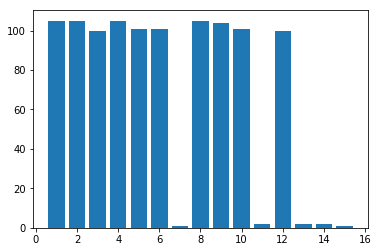

In [30]:
import matplotlib.pyplot as plt

plt.bar(range(1, 16), counts)
plt.show()

# Training

In [48]:
index_train, index_test, labels_train, labels_test = \
    train_test_split(np.asarray(range(len(all_labels))), all_labels, test_size=0.2, random_state = 42, shuffle = True)

arrows_train = all_arrows[index_train]
arrows_test = all_arrows[index_test]

tokens_train = all_tokens[index_train]
tokens_test = all_tokens[index_test]

(arrows_train.shape, tokens_train.shape, labels_train.shape), (arrows_test.shape, tokens_test.shape, labels_test.shape)


(((59229, 16, 16), (59229, 3), (59229, 255)),
 ((14808, 16, 16), (14808, 3), (14808, 255)))

In [0]:
def build(arrows_shape, token_shape, output_shape, silent = True):
    arrows = Input(shape = (arrows_shape[1], arrows_shape[2],))
    tokens = Input(shape = (token_shape[1],))
    #tokens = Input(shape = (token_shape[1], token_shape[2],))
    
    x = Bidirectional(LSTM(128, kernel_initializer='glorot_normal', return_sequences = True))(arrows)
    x = Bidirectional(LSTM(64, kernel_initializer='glorot_normal'))(x)
    x = BatchNormalization()(x)
    x = Model(inputs = arrows, outputs = x)
    
    y = Dense(16, kernel_initializer='glorot_normal', activation = "relu")(tokens)
    #y = LSTM(128, kernel_initializer='glorot_normal')(y)
    y = Model(inputs = tokens, outputs = y)
    
    combined = concatenate([x.output, y.output])
    
    z = Dense(64, kernel_initializer='glorot_normal', activation = "relu")(combined)
    z = Dropout(0.25)(z)
    z = Dense(output_shape[1], activation = "softmax")(z)
    
    model = Model(inputs = [x.input, y.input], outputs = z)
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    
    if not silent: 
        model.summary()
    
    return model

In [50]:
model = build(arrows_train.shape, tokens_train.shape, labels_train.shape, silent = False)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16, 16)       0                                            
__________________________________________________________________________________________________
bidirectional_11 (Bidirectional (None, 16, 256)      148480      input_11[0][0]                   
__________________________________________________________________________________________________
bidirectional_12 (Bidirectional (None, 128)          164352      bidirectional_11[0][0]           
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 3)            0                                            
__________________________________________________________________________________________________
batch_norm

In [51]:
batch_size = 256
model = build(arrows_train.shape, tokens_train.shape, labels_train.shape, silent = True)

callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=0),
             ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=2, min_lr=0.001)]

history = model.fit([arrows_train, tokens_train], 
                    labels_train,
                    validation_data=([arrows_test, tokens_test], labels_test),
                    epochs = 100,
                    callbacks = callbacks,
                    batch_size= batch_size,
                    verbose = 1)

Train on 59229 samples, validate on 14808 samples
Epoch 1/100
59229/59229 [==============================] - 43s 734us/step - loss: 1.7271 - acc: 0.4238 - val_loss: 1.3413 - val_acc: 0.4793
Epoch 2/100
59229/59229 [==============================] - 39s 653us/step - loss: 1.3057 - acc: 0.5089 - val_loss: 1.2790 - val_acc: 0.5107
Epoch 3/100
59229/59229 [==============================] - 38s 648us/step - loss: 1.2392 - acc: 0.5282 - val_loss: 1.2179 - val_acc: 0.5278
Epoch 4/100
59229/59229 [==============================] - 38s 646us/step - loss: 1.2137 - acc: 0.5339 - val_loss: 1.2178 - val_acc: 0.5276
Epoch 5/100
59229/59229 [==============================] - 38s 646us/step - loss: 1.1980 - acc: 0.5385 - val_loss: 1.1995 - val_acc: 0.5355
Epoch 6/100
59229/59229 [==============================] - 38s 647us/step - loss: 1.1853 - acc: 0.5420 - val_loss: 1.1933 - val_acc: 0.5373
Epoch 7/100
59229/59229 [==============================] - 38s 640us/step - loss: 1.1736 - acc: 0.5475 - val_l

# Predicting

In [0]:
model.save("arrow_placement_model.h5")

In [79]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories='auto', sparse = False).fit(np.asarray(get_all_note_combs()).reshape(-1, 1))
pred_notes = []
ex_timings = notes_by_song[0][:,1]
ex_tokens = np.expand_dims(create_tokens(ex_timings), axis = 1)
notes_ngram = np.expand_dims(get_notes_ngram(np.zeros((1, 16)), lookback)[-1], axis = 0)
for i, token in enumerate(ex_tokens):
    pred_arrow = np.argmax(model.predict([notes_ngram, token]))
    binary_rep = encoder.categories_[0][pred_arrow]
    pred_notes.append(binary_rep) 
    binary_note = get_extended_binary_rep([binary_rep])
    notes_ngram = np.roll(notes_ngram, -1, axis = 0)
    notes_ngram[0][-1] = binary_note
    print(i, notes_ngram[0][-1], binary_rep)

0 [0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 1000
1 [1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 0001
2 [0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 1000
3 [1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 0001
4 [0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 1000
5 [1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 0001
6 [0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 1000
7 [1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 0001
8 [0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 1000
9 [1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 0001
10 [0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 1000
11 [1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 0001
12 [0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 1000
13 [1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 0001
14 [0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 1000
15 [1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 0001
16 [0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 1000
17 [1. 1. 1. 0. 0. 0. 0.